# Darts: Deep Forecasting

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from darts import TimeSeries
from darts.models import ExponentialSmoothing as ETS
from darts.models import StatsForecastAutoARIMA as AutoARIMA
from darts.models import LightGBMModel, CatBoostModel, XGBModel
from darts.metrics import mape as MAPE
from darts.metrics import mase as MASE
from darts.metrics import mae as MAE
from darts.utils.statistics import stationarity_tests

import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

## 1. Darts API

### 1.1. Time series container
[`TimeSeries`] is the main data class in Darts. There can be various instaniation ways, but it is recommended to do this *indirectly* from a Pandas dataframe with `DatetimeIndex`, which is usually obtained via the [`asfreq()`] method for easy data cleaning.

[`TimeSeries`]: https://unit8co.github.io/darts/generated_api/darts.timeseries.html
[`asfreq()`]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

In [26]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from darts import TimeSeries

import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [60]:
dfEco = (
    pd.read_csv('../data/macroeconomic.csv')
    .astype({'period': 'datetime64'})
    .set_index('period')
    .asfreq('QS')
)
tsEco = TimeSeries.from_dataframe(dfEco)

In [61]:
tsEco.pd_dataframe()

component,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
period,,,,,,,,,,,,
1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-07-01,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-10-01,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-01-01,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71


#### Basic methods

In [39]:
tsEco.dtype

dtype('float64')

In [40]:
tsEco.freq

<QuarterBegin: startingMonth=1>

In [41]:
tsEco.columns

Index(['realgdp', 'realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1',
       'tbilrate', 'unemp', 'pop', 'infl', 'realint'],
      dtype='object', name='component')

In [60]:
tsEco.n_components

12

In [64]:
tsEco.n_timesteps

203

In [65]:
tsEco.duration

Timedelta('18444 days 00:00:00')

#### Slicing
Luckily, the slicing syntaxes is almost similar to Pandas dataframes. Except when you want to access specific times, we must use an appropriate Pandas object: a [`Timestamp`] for a single time, or a [`DatetimeIndex`] for multiple times. The later case can also be done indirectly with the help of the [`date_range()`] function.

[`Timestamp`]: https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html
[`DatetimeIndex`]: https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html
[`date_range()`]: https://pandas.pydata.org/docs/reference/api/pandas.date_range.html

In [40]:
# select a series
tsEco['realgdp']

# select multiple series
tsEco[['realgdp', 'realcons']]

pass

In [41]:
# select last 10 observations
tsEco[-10:]

# split the time series by ratio
tsEco.split_after(0.8)

# access a specific time stamp
tsEco[pd.Timestamp('2002-07-01')]

# access multiple time stamps
tsEco[pd.date_range(start='1959-01-01', end='1960-01-01', freq='QS')]

pass

#### Plotting

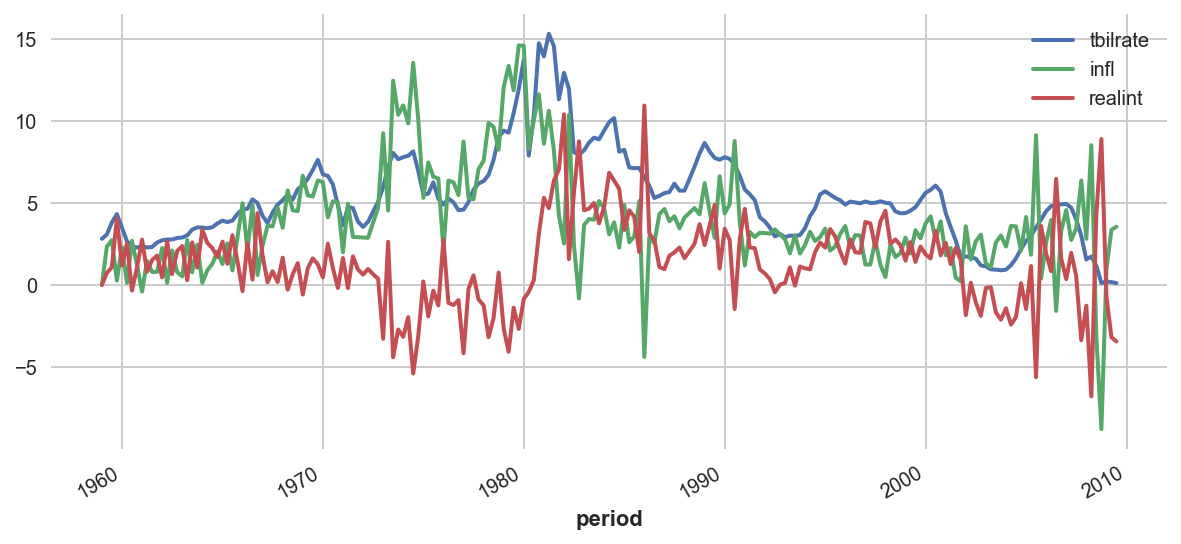

In [62]:
fig, ax = plt.subplots(figsize=(10,4))
tsEco[['tbilrate', 'infl']].plot()
tsEco['realint'].plot()

### 1.2. Data enrichment
With a univariate time series, there can be a lot of ways to create additional data. This section guides us through some techniques, made easy with Darts:
- basic time series transformations such as `diff()`, `lag()` and `shift()`
- `map()` the series to a new one using any Numpy function, then `stack()` it to the original
- `add_datetime_attribute()` to extract *cyclic attributes* from [`DatetimeIndex`](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html)
- `add_holidays()` to get a binary component representing holidays for a specific country, which reduces the need of [`CustomBusinessDay`](https://pandas.pydata.org/docs/reference/api/pandas.tseries.offsets.CustomBusinessDay.html)

In [24]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from darts import TimeSeries

import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [46]:
dfQty = (
    pd.read_csv('../data/weekly_quantity.csv')
    .eval("date = date.astype('datetime64')", engine='python')
    .set_index('date')
)
tsQty = TimeSeries.from_dataframe(dfQty)

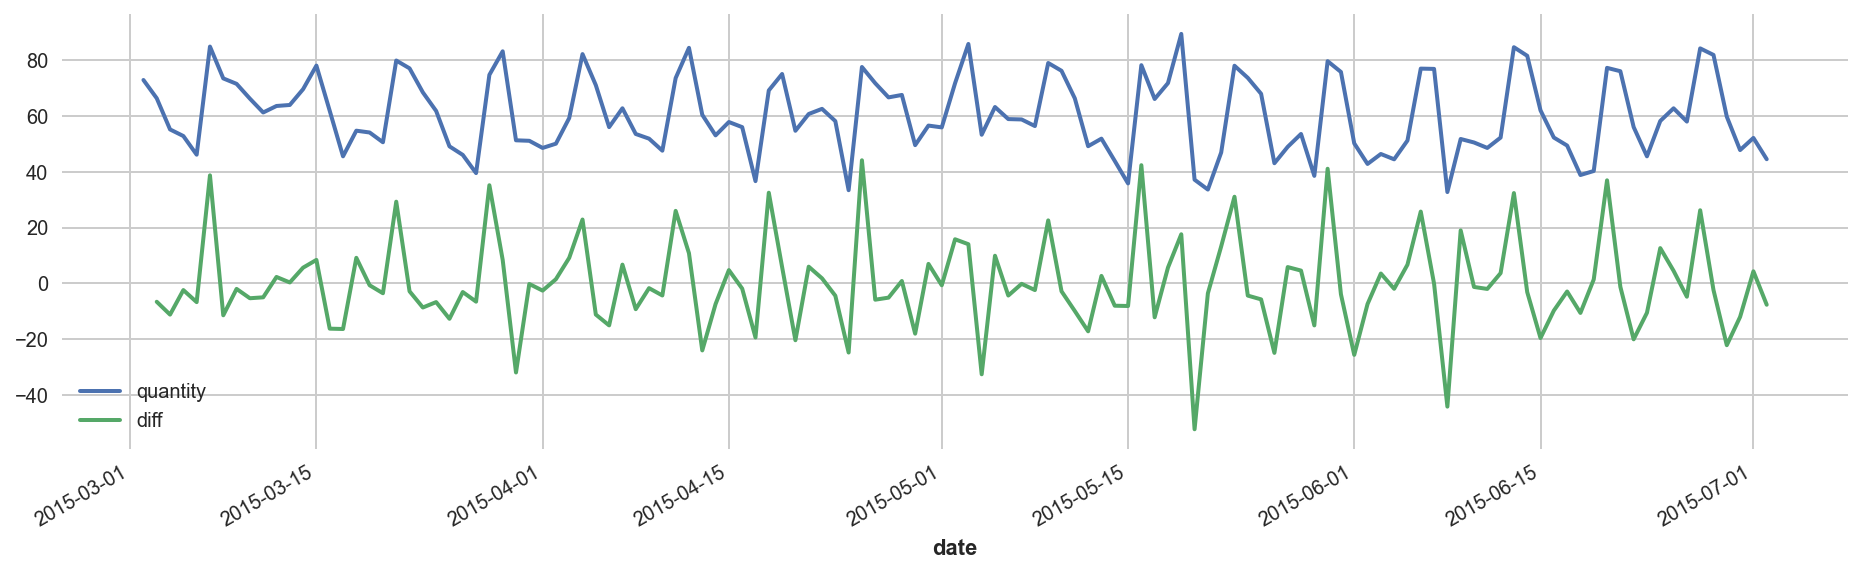

In [80]:
plt.figure(figsize=(16,4))
tsQty.plot()
tsQty.diff(1).plot(label='diff')

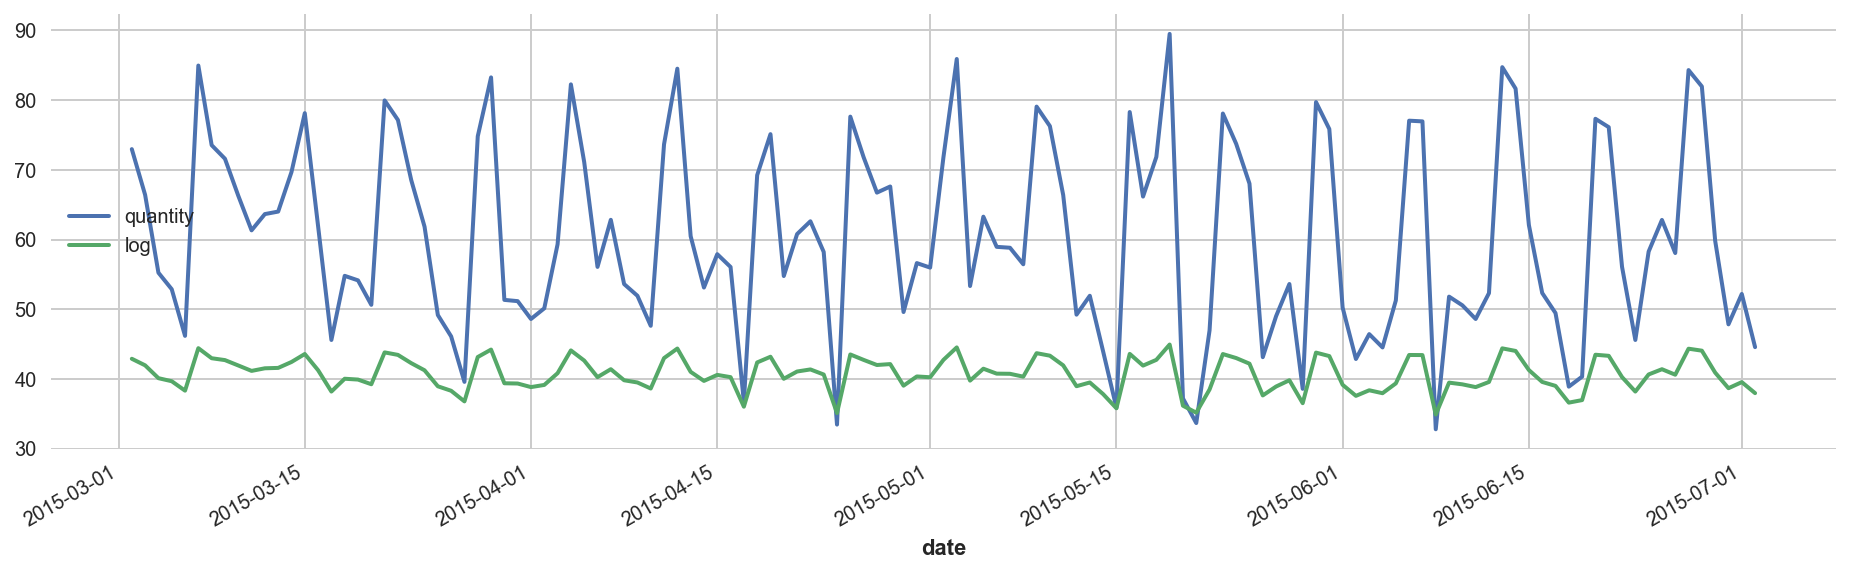

In [104]:
tsLog = tsQty.with_columns_renamed('quantity', 'log').map(np.log)*10

plt.figure(figsize=(16,4))
tsQty.stack(tsLog).plot()

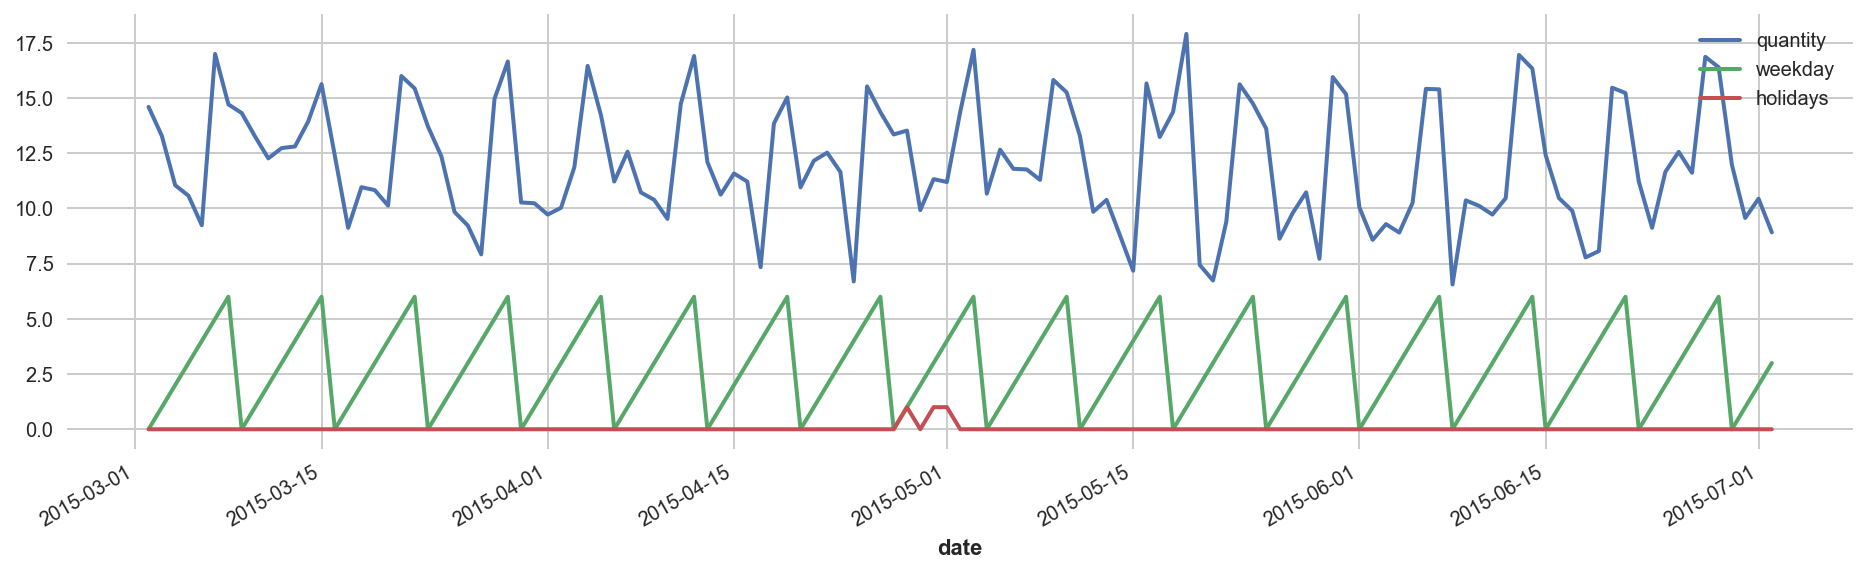

In [49]:
plt.figure(figsize=(16,4))
(tsQty/5).add_datetime_attribute('weekday').add_holidays('VN').plot()

### 1.3. Forecasting
Darts unifies a wide range of common forecasting algorithms, which can be found [here](https://github.com/unit8co/darts#forecasting-models). They use the same

In [24]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from darts import TimeSeries
from darts.models import ExponentialSmoothing as ETS
from darts.models import StatsForecastAutoARIMA as AutoARIMA
from darts.models import LightGBMModel, CatBoostModel, XGBModel
from darts.metrics import mape as MAPE
from darts.metrics import mase as MASE
from darts.metrics import mae as MAE
from darts.utils.statistics import stationarity_tests

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [4]:
dfEco = (
    pd.read_csv('../data/macroeconomic.csv')
    .astype({'period': 'datetime64'})
    .set_index('period')
    .asfreq('QS')
)
tsEco = TimeSeries.from_dataframe(dfEco)

In [5]:
dfEco.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
period,,,,,,,,,,,,
1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [47]:
tsTrain = tsEco['realgovt'][:-20]
tsTest = tsEco['realgovt'][-20:]

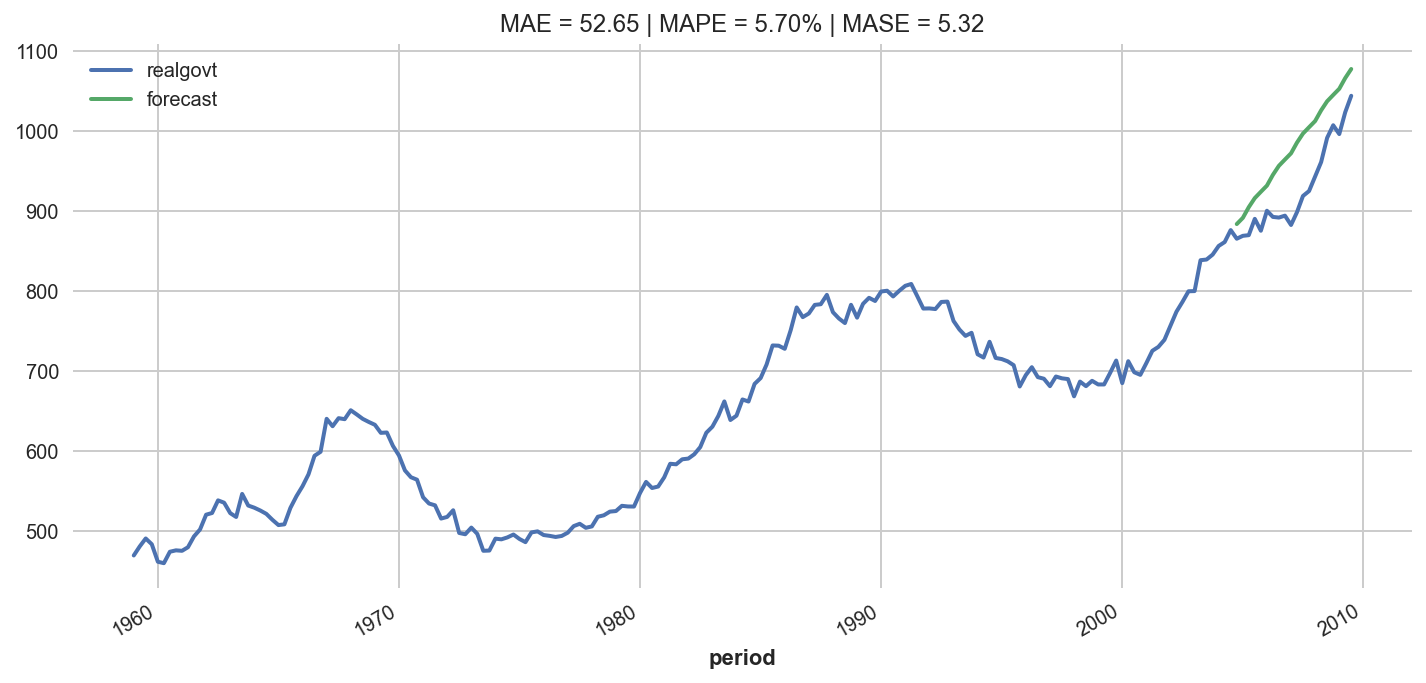

In [45]:
# fit-predict API just like Scikit-learn
model = ETS()
model.fit(tsTrain)
tsPred = model.predict(20)

# evaluation metrics
mae = MAE(tsTest, tsPred)
mape = MAPE(tsTest, tsPred) / 100
mase = MASE(tsTest, tsPred, tsTrain)

plt.figure(figsize=(12,5))
tsEco['realgovt'].plot()
tsPred.plot(label='forecast')
plt.title(f'MAE = {mae:.2f} | MAPE = {mape:.2%} | MASE = {mase:.2f}')
plt.show()

#### Probabilistic forecast
Prediction interval is an important output of forecasting problems, mainly because of high error and data drift. Unfortunately, a number of forecasting algorithms in Darts does not support this feature, so we carefully select and implement only algorithms with this ability.
- For most statistical algorithms (traditional [`StatsForecastAutoARIMA`], [`ExponentialSmoothing`], [`TBATS`] and modern [`Prophet`]), they support this feature by nature. To request probabilistic forecasts, Darts performs Monte Carlo sampling (via the parameter `num_samples` during prediction) to construct a distribution for predicted values. Hundreds of Monte Carlo samples should be enough to provide a reliable result. Finally, call the [`quantiles_df()`] method on the sampled series to extract predictions at specific quantiles.
- For reduction-to-regression methods ([`XGBModel`], [`LightGBMModel`] and [`CatBoostModel`]), we must specify the `likelihood` parameter during model initialization. Doing so will overwirte the objective function of the regression algorithm and enables probabilistic prediction. Requesting prediction is the same.
- For recurrent networks, we must also specify a `likelihood`; but this parameter accepts a [likelihood model](https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.html#) rather than a string. Requesting prediction is the same.

[`quantiles_df()`]: https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.quantiles_df
[`StatsForecastAutoARIMA`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.sf_auto_arima.html
[`ExponentialSmoothing`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.exponential_smoothing.html
[`TBATS`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tbats.html#darts.models.forecasting.tbats.TBATS
[`Prophet`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.prophet_model.html
[`RegressionModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html
[`XGBModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.xgboost.html
[`LightGBMModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.lgbm.html
[`CatBoostModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.catboost_model.html

In [39]:
model = AutoARIMA()
model.fit(tsTrain)
tsPred = model.predict(5, num_samples=100)
tsPred.quantiles_df((0.05, 0.5, 0.95))

component,realgovt_0.05,realgovt_0.5,realgovt_0.95
period,,,
2004-10-01,859.778029,878.973368,894.436742
2005-01-01,853.138987,877.747642,907.254163
2005-04-01,852.227291,882.300101,913.823995
2005-07-01,850.728000,889.882035,923.080659
2005-10-01,856.773183,887.636369,935.293484


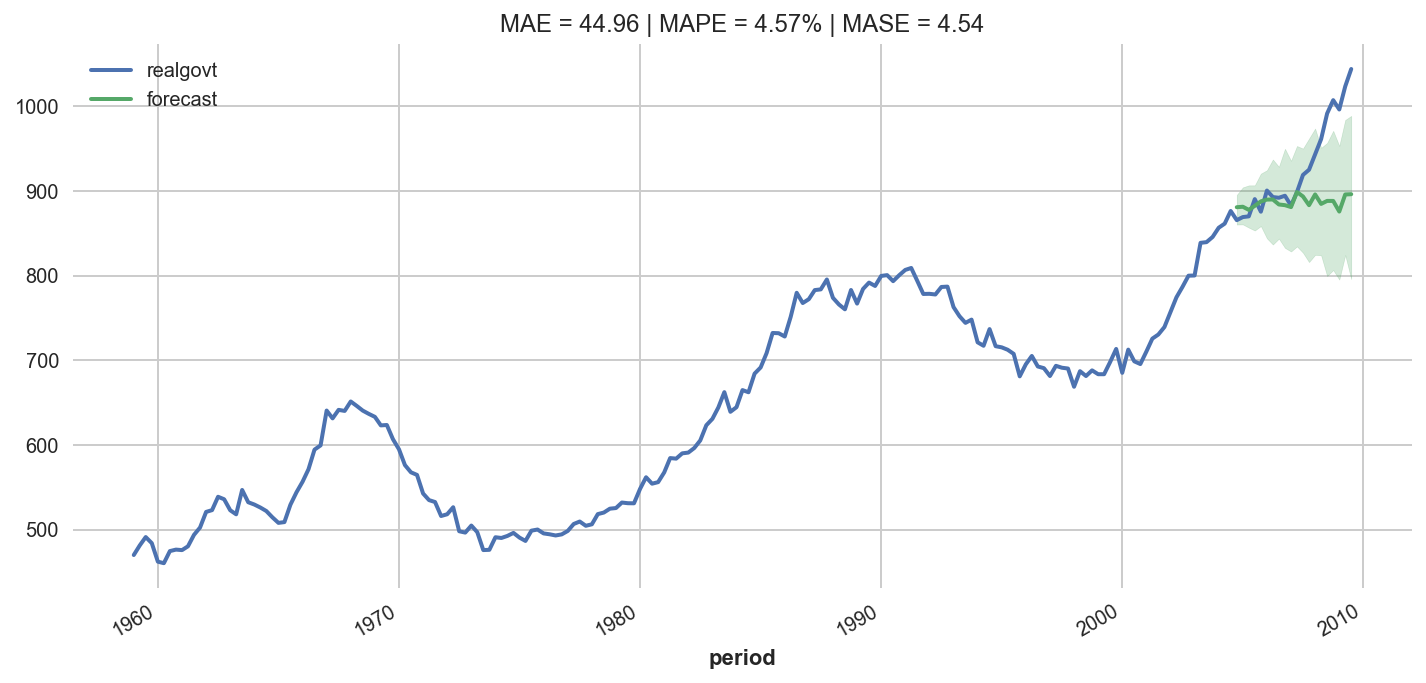

In [42]:
tsPred = model.predict(20, num_samples=100)
mae = MAE(tsTest, tsPred)
mape = MAPE(tsTest, tsPred) / 100
mase = MASE(tsTest, tsPred, tsTrain)

plt.figure(figsize=(12,5))
tsEco['realgovt'].plot()
tsPred.plot(label='forecast', low_quantile=0.1, high_quantile=0.9)
plt.title(f'MAE = {mae:.2f} | MAPE = {mape:.2%} | MASE = {mase:.2f}')
plt.show()

### 1.4. Covariates
Real-world time series are highly affected by external factors, which are called *covariates* by Darts. Taking these data into consideration, if done correctly, can improve forecasting quality a lot, especially in modeling trends. There are mainly two types of covariates:
- *Past covariates*: covariates known only into the past, such as purchased quantity. In practice, data are usually of this type.
- *Future covariates*: covariates known into the future, such as weather forecasts and holidays. This data is harder to collect and is thus rarely used.

In [25]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from darts import TimeSeries
from darts.models import ExponentialSmoothing as ETS
from darts.models import StatsForecastAutoARIMA as AutoARIMA
from darts.models import LightGBMModel, CatBoostModel, XGBModel
from darts.metrics import mape as MAPE
from darts.metrics import mase as MASE
from darts.metrics import mae as MAE
from darts.utils.statistics import stationarity_tests

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [28]:
dfEco = (
    pd.read_csv('../data/macroeconomic.csv')
    .astype({'period': 'datetime64'})
    .set_index('period')
    .asfreq('QS')
)
tsEco = TimeSeries.from_dataframe(dfEco)

In [29]:
tsTrain = tsEco['realgovt'][:-20]
tsTest = tsEco['realgovt'][-20:]

#### Future covariates
Most important algorithms support future covariates, except for TBATS and some Deep Learning models. In fact, they have been introduced in the early days of forecasting models under the name *exogenous* (while the original series is called *endogenous*).

As stated earlier, future covariates are simply deterministic events such as holidays and weekdays. Darts provides a convenient way to produces such features by specifying datetime attributes, using the parameter `add_encoders` in the supported algorithms. The detailed usage can be found [here](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html).

In [30]:
futureCovar = {
    'cyclic': {'future': ['quarter']},
    'datetime_attribute': {'future': ['dayofweek']},
}

model = AutoARIMA(add_encoders=futureCovar)
model.fit(tsTrain)

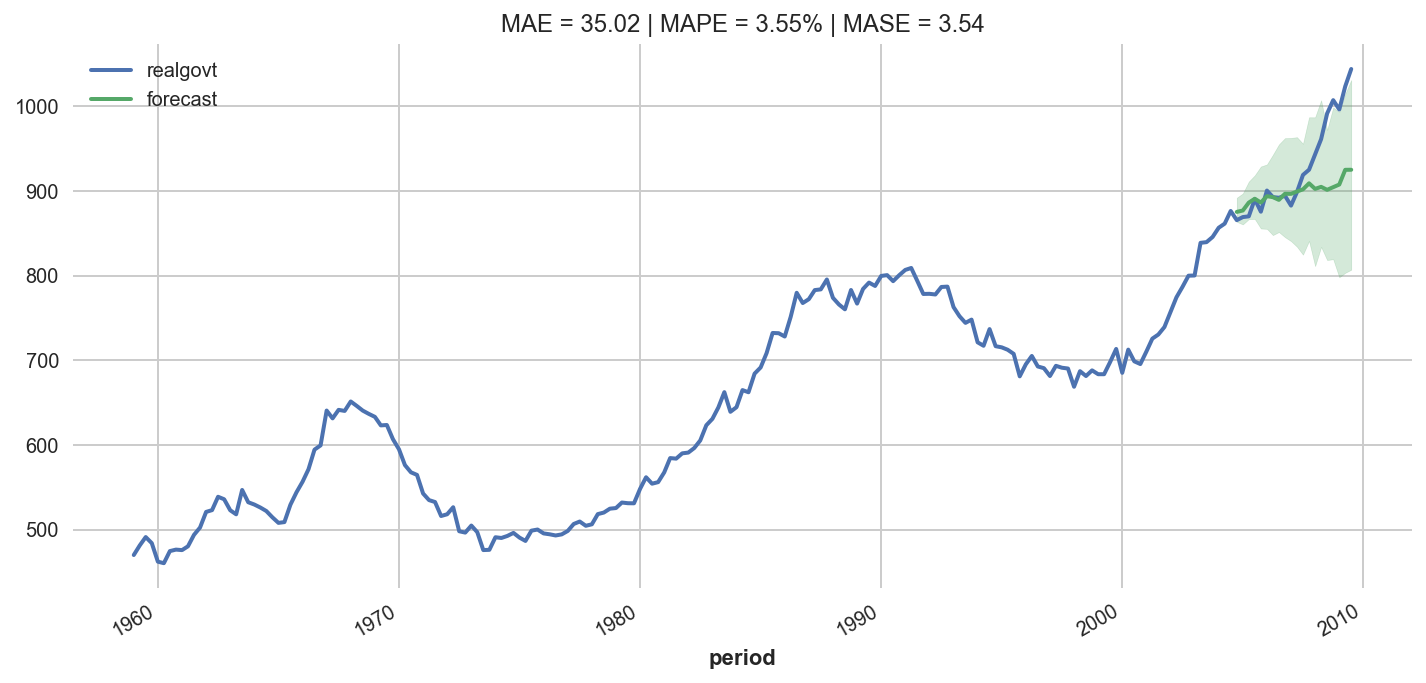

In [31]:
tsPred = model.predict(20, num_samples=100)
mae = MAE(tsTest, tsPred)
mape = MAPE(tsTest, tsPred) / 100
mase = MASE(tsTest, tsPred, tsTrain)

plt.figure(figsize=(12,5))
tsEco['realgovt'].plot()
tsPred.plot(label='forecast', low_quantile=0.1, high_quantile=0.9)
plt.title(f'MAE = {mae:.2f} | MAPE = {mape:.2%} | MASE = {mase:.2f}')
plt.show()

#### Past covariates
Past covariate is a way more powerful feature, but is not a part of statistical algorithms, namely: ARIMA, ETS and Prophet. It is supported by Darts in regression reductions and recurrent networks. There are two ways to build a forecasting model with past covariates:
- Shifting past covariates to the right, which makes them known to the future. Further horizons require shifting more, so we are wasting a lot of information.
- Build a model to predict each time step in the future (by specifying `output_chunk_length`). Require more models to be trained, but will be more effective.

It is recommended to use the second strategy in practice as (1) forecasting models don't use a lot of data, (2) simple implementation and (3) better performance.

In [32]:
tsTrain = tsEco['realgovt'][:-20]
tsTest = tsEco['realgovt'][-20:]
tsCovar = tsEco[['realinv', 'tbilrate', 'unemp', 'realint']][:-20]

In [33]:
lagPastCovariates = 8
params = dict(
    lags=12,
    lags_past_covariates=2, 
    n_estimators=500,
    learning_rate=0.03,
    likelihood='quantile',
    output_chunk_length=20, 
)

model = LightGBMModel(**params)
model.fit(tsTrain.diff(), past_covariates=tsCovar)

# predict diff
tsPred = model.predict(20, num_samples=100)

In [34]:
def revert_diff(tsTrain, tsDiff):
    nSample = tsDiff.n_samples
    idx = tsTrain[-1].time_index
    data = np.repeat(tsTrain[-1].all_values(), nSample).reshape(1,1,-1)
    tsTrain = TimeSeries.from_times_and_values(idx, data)

    trans = dict(function='sum', mode='expanding', window=1)
    tsCsum = tsTrain[-1].append(tsDiff).window_transform(trans)[1:]
    return tsCsum

tsPred = revert_diff(tsTrain, tsPred)

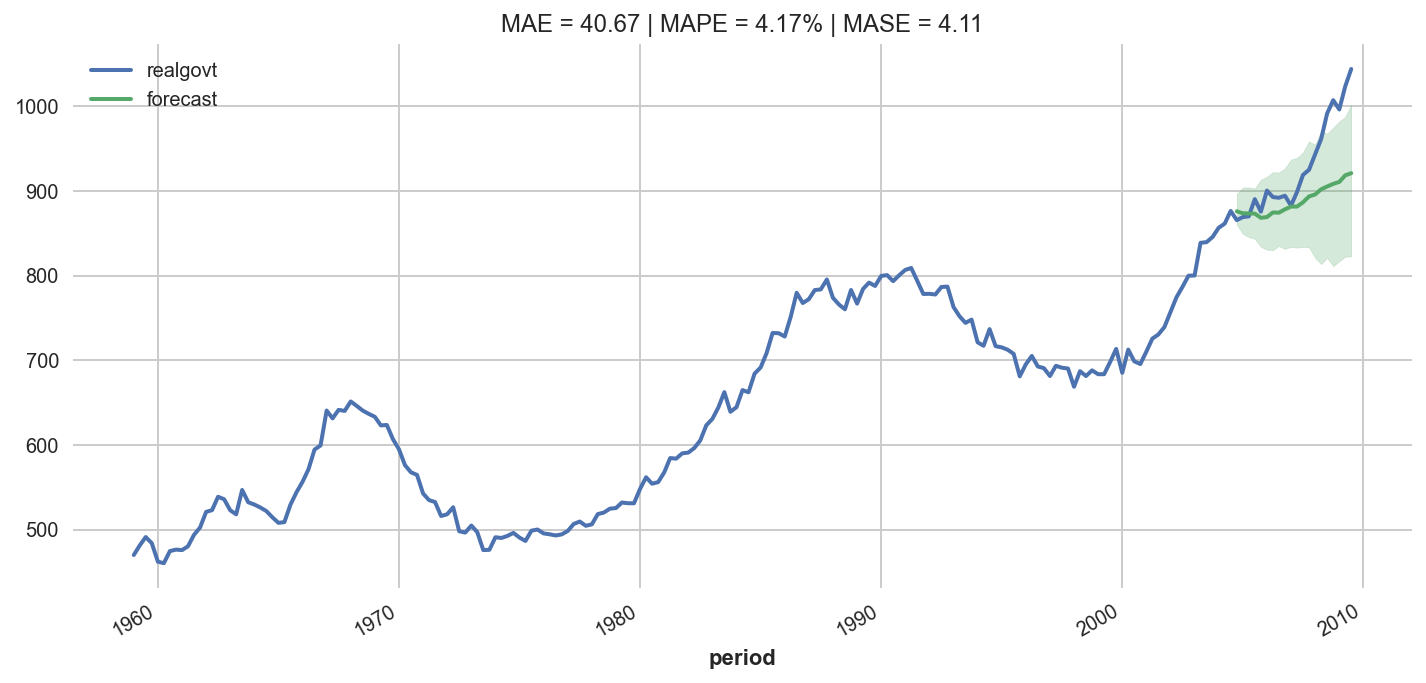

In [35]:
mae = MAE(tsTest, tsPred)
mape = MAPE(tsTest, tsPred) / 100
mase = MASE(tsTest, tsPred, tsTrain)

plt.figure(figsize=(12,5))
tsEco['realgovt'].plot()
tsPred.plot(label='forecast')
plt.title(f'MAE = {mae:.2f} | MAPE = {mape:.2%} | MASE = {mase:.2f}')
plt.show()

### 1.5. Backtesting
Backtesting is another important aspect when solving, can be thought as the validation step for forecasting problems. Every forecasting models in Darts has two methods, `historical_forecasts()` for computing historical predictions at each cutoff (also called backcasts) and `backtest()` for computing average scores. Both use the same parameters:
- `start`: the cutoff point to start backtesting, defaults to *None* (automatically determined). Can be set to a float (fraction of data from index 0), an integer (index) or a specific timestamp.
- `stride`: the number of time steps between two cutoffs, defaults to *1*.
- `train_length`: the number of training data used for each cutoff, defaults to *None* (using all data from index 0, equivalent to expanding window). Can be set to an integer, equivalent to rolling window strategy.
- `forecast_horizon `: the length of forecasting horizon, defaults to *1*.
- `retrain`: whether to retrain the model at each iteration, defaults to *True*.
- `metric`: the scoring function, defaults to *MAPE*. Can be either a single of a list of Dart's scoring functions.
- `reduction`: the aggregate function to summary scores at different cutoffs, defaults to *np.mean*. Can set to *None*, which will return all scores.
- `series`, `past_covariates `, `future_covariates`, `num_samples`: same usage as in the `predict()` method.


In [36]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import ExponentialSmoothing as ETS
from darts.models import StatsForecastAutoARIMA as AutoARIMA
from darts.models import LightGBMModel, CatBoostModel, XGBModel
from darts.metrics import mape as MAPE
from darts.metrics import mase as MASE
from darts.metrics import mae as MAE
from darts.utils.statistics import stationarity_tests

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [2]:
dfEco = (
    pd.read_csv('../data/macroeconomic.csv')
    .astype({'period': 'datetime64'})
    .set_index('period')
    .asfreq('QS')
)
tsEco = TimeSeries.from_dataframe(dfEco)

In [3]:
tsTrain = tsEco['realgovt'][:-20]
tsTest = tsEco['realgovt'][-20:]
tsCovar = tsEco[['realinv', 'tbilrate', 'unemp', 'realint']][:-20]

In [4]:
model = AutoARIMA()
model.fit(tsTrain)
tsPred = model.predict(5)

In [14]:
paramsBacktest = dict(
    series=tsTrain,
    past_covariates=tsCovar,
    num_samples=100,
    start=pd.Timestamp('1970-01-01'),
    stride=40,
    last_points_only=False,
    forecast_horizon=12,
)

In [15]:
listDate = pd.date_range('1970-01-01', tsTrain.time_index[-1], freq='40QS')
listScore = model.backtest(metric=[MAPE, MAE], reduction=None, **paramsBacktest)
for date, (mape, mae) in zip(listDate, listScore):
    print(f'{date} | MAPE={mape/100:.2%} | MAE={mae:.2f}')

1970-01-01 00:00:00 | MAPE=12.80% | MAE=67.23
1980-01-01 00:00:00 | MAPE=8.30% | MAE=48.85
1990-01-01 00:00:00 | MAPE=1.48% | MAE=11.77
2000-01-01 00:00:00 | MAPE=3.53% | MAE=26.55


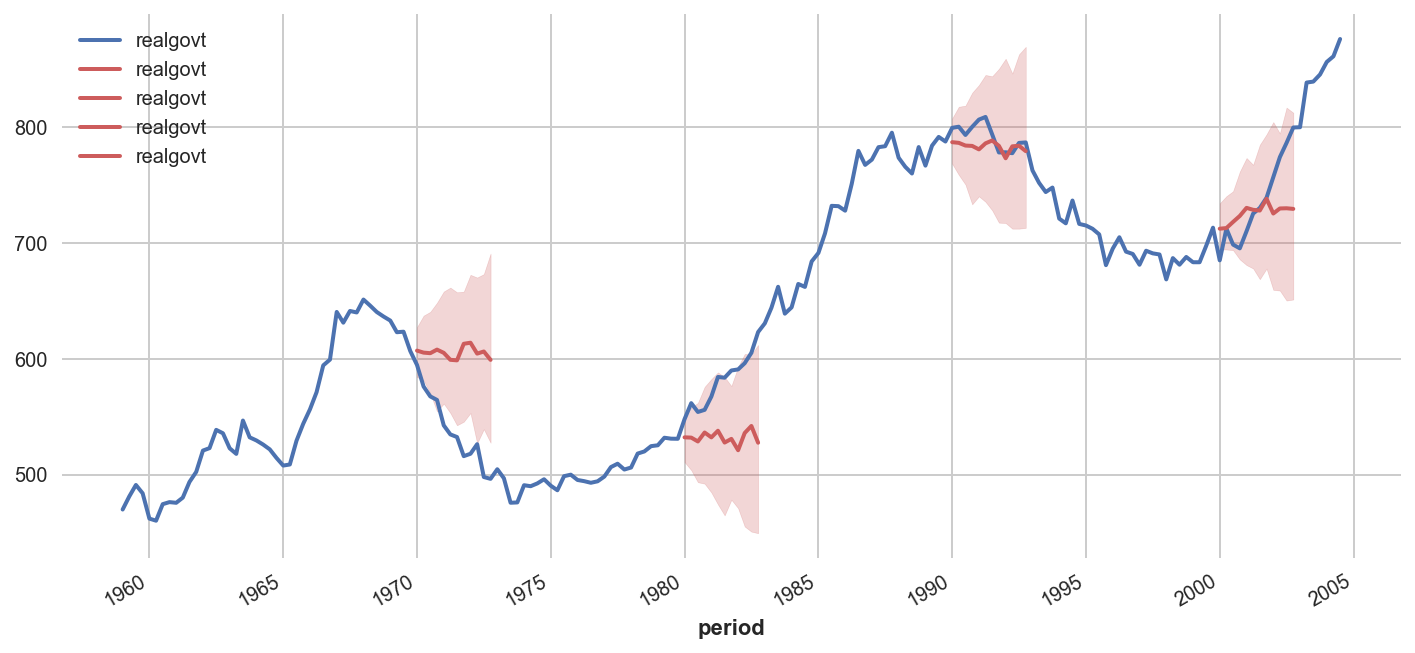

In [26]:
listBackcast = model.historical_forecasts(**paramsBacktest)

plt.figure(figsize=(12,5))
tsTrain.plot()
for backcast in listBackcast:
    backcast.plot(color='indianred')

:::{tip}

The `backtest()` method is designed for hyperparameter tuning, it does not support testing at a specific time. A workaround solution is to provide a timestamp and a large stride.

:::

In [72]:
paramsBacktest = dict(
    series=tsTrain,
    past_covariates=tsCovar,
    start=pd.Timestamp('1970-01-01'),
    stride=tsTrain.n_timesteps,
    last_points_only=False,
    forecast_horizon=5,
)

model.backtest(**paramsBacktest)

6.7082212689969865

## 2. Deep forecasters

### 2.1. DeepAR
- API: [`BlockRNNModel`]
- Year: 2017
- Paper: [DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks](https://arxiv.org/abs/1704.04110)

[`BlockRNNModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.block_rnn_model.html

### 2.2. Transformer
- API: [`TransformerModel`]
- Year: 2017
- Paper: [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

[`TransformerModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.transformer_model.html

### 2.3. N-BEATS
- API: [`NBEATSModel`]
- Year: 2019
- Paper: [N-BEATS: Neural basis expansion analysis for interpretable time series forecasting](https://arxiv.org/abs/1905.10437)

>

- API: [`NHiTSModel`]
- Year: 2022
- Paper: [N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting](https://arxiv.org/abs/2201.12886)


[`NBEATSModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
[`NHiTSModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nhits.html

### 2.4. TCN
- API: [`TCNModel`]
- Year: 2019
- Paper: [Probabilistic Forecasting with Temporal Convolutional Neural Network](https://arxiv.org/abs/1906.04397)

[`TCNModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html

### 2.5. TFT
- API: [`TFTModel`]
- Year: 2019
- Paper: [Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting](https://arxiv.org/abs/1912.09363)

[`TFTModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html#id1

### 2.6. LTSF-Linear
- API: [`DLinearModel`], [`NLinearModel`]
- Year: 2022
- Paper: [Are Transformers Effective for Time Series Forecasting?](https://arxiv.org/abs/2205.13504)

[`DLinearModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.dlinear.html
[`NLinearModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nlinear.html